# Setup

In [1]:
## Imports

%matplotlib inline
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML

from ts_outlier_detection import *
from ts_outlier_detection.plotting import *

from gwpy.signal import filter_design
from gwpy.timeseries import TimeSeries

from tqdm.notebook import tqdm

In [2]:
## Data fetching and pre-processing functions

BANDPASS = (20, 500)

def downsample_timeseries(data, ratio, sampler=None):
    ds = data[::ratio]
    if sampler is not None:
        data = np.append(data, np.full(data.size % ratio, data[-1]))
        bins = data.reshape(ratio, -1)
        ds = sampler(bins)
    return ds

def get_processed_event(
    detector, gps_time, length=10, offset=0, edges=1, downsample=1, sampler=None
):
    ts = get_raw_event(detector, gps_time, length, offset, edges)
    border = int(edges/ts.dt.value)
    ts = preprocess_timeseries(ts)[border:-border]
    return downsample_timeseries(ts, downsample, sampler)


def get_raw_event(detector, gps_time, length=10, offset=0, edges=1):
    bracket = edges + length/2
    t0 = gps_time - bracket + offset
    t1 = gps_time + bracket + offset
    return TimeSeries.fetch_open_data(detector, t0, t1, cache=True)
    

def preprocess_timeseries(ts, bp=BANDPASS):
    # Whiten
    ts = ts.whiten()
    # Bandpass
    ts = ts.bandpass(*bp)
    return ts

In [3]:
## Plotting functions

def plot_omegascan_detections(ax, ts, detections, ypos=BANDPASS[0]-10, **kwargs):
    image = ax.pcolormesh(ts.q_transform(**kwargs), vmin=0, vmax=15, zorder=1)
    plotx = ts.times.value[detections]
    ploty = np.full(ts.times.value.shape, ypos)[detections]
    markers, = ax.plot(plotx, ploty, 'k.', zorder=2)
    ax.set_ylim(0, 300)
    ax.colorbar()
    return [image, markers]

def plot_tof_comparison(hdata, title=None, **kwargs):
    fig = plt.figure(figsize=(18, 6), constrained_layout=True)
    gs = fig.add_gridspec(2, 2)
    bax = fig.add_subplot(gs[1,0])
    bax.set_ylabel('TOF')
    bax.set_xlabel('GPS Time (s)')
    tax = fig.add_subplot(gs[0,0], sharex=bax)
    tax.set_ylabel('Strain')
    if title is not None:
        tax.set_title(title)
    oax = fig.add_subplot(gs[:,1])
    oax.set_ylabel('Frequency (Hz)')
    oax.set_xlabel('GPS Time (s)')

    ctof = TemporalOutlierFactor(**kwargs)
    data = hdata.value
    times = hdata.times.value
    ctof.fit(data, times)
    plot_ts_outliers(ctof, (tax, bax))
    plot_omegascan_detections(oax, hdata, ctof.get_outlier_indices())

# Events

In [4]:
hdata = get_processed_event('H1', 1242242376.47, length=120)

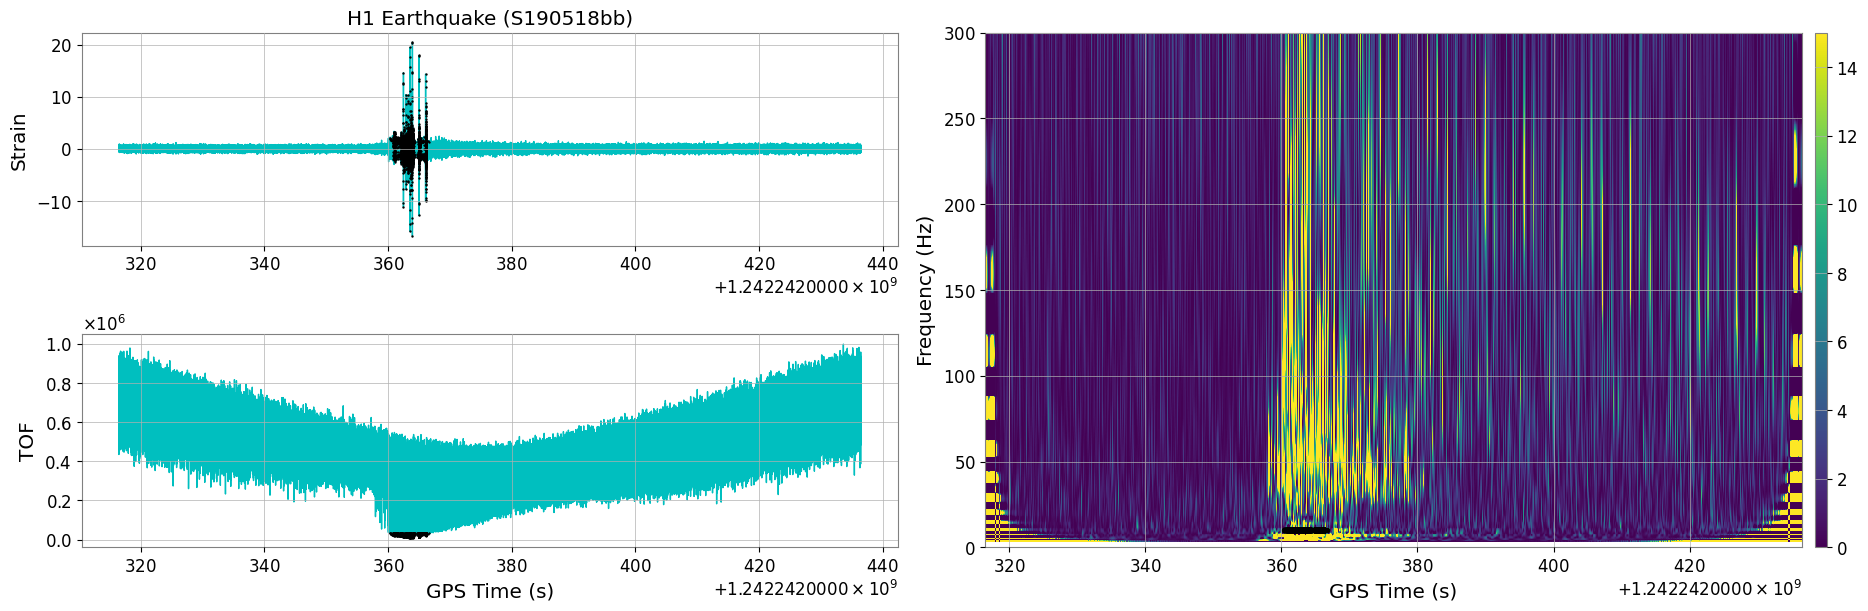

In [5]:
plot_tof_comparison(
    hdata, title='H1 Earthquake (S190518bb)',
    dims=3, n_neighbors=20, event_length=2**15
)

In [6]:
## Retracted events

RETRACTED_O3 = {
    'S190928c': 1253671923.33,
    'S190829u': 1251147973.28,
    'S190822c': 1250472616.59,
    'S190816i': 1249995888.76,
    'S190808ae': 1249338098.50,
    'S190524q': 1242708743.68,
    'S190405ar': 1238515307.86
}

DETECTORS = ['H1', 'L1', 'V1']

  0%|          | 0/21 [00:00<?, ?it/s]

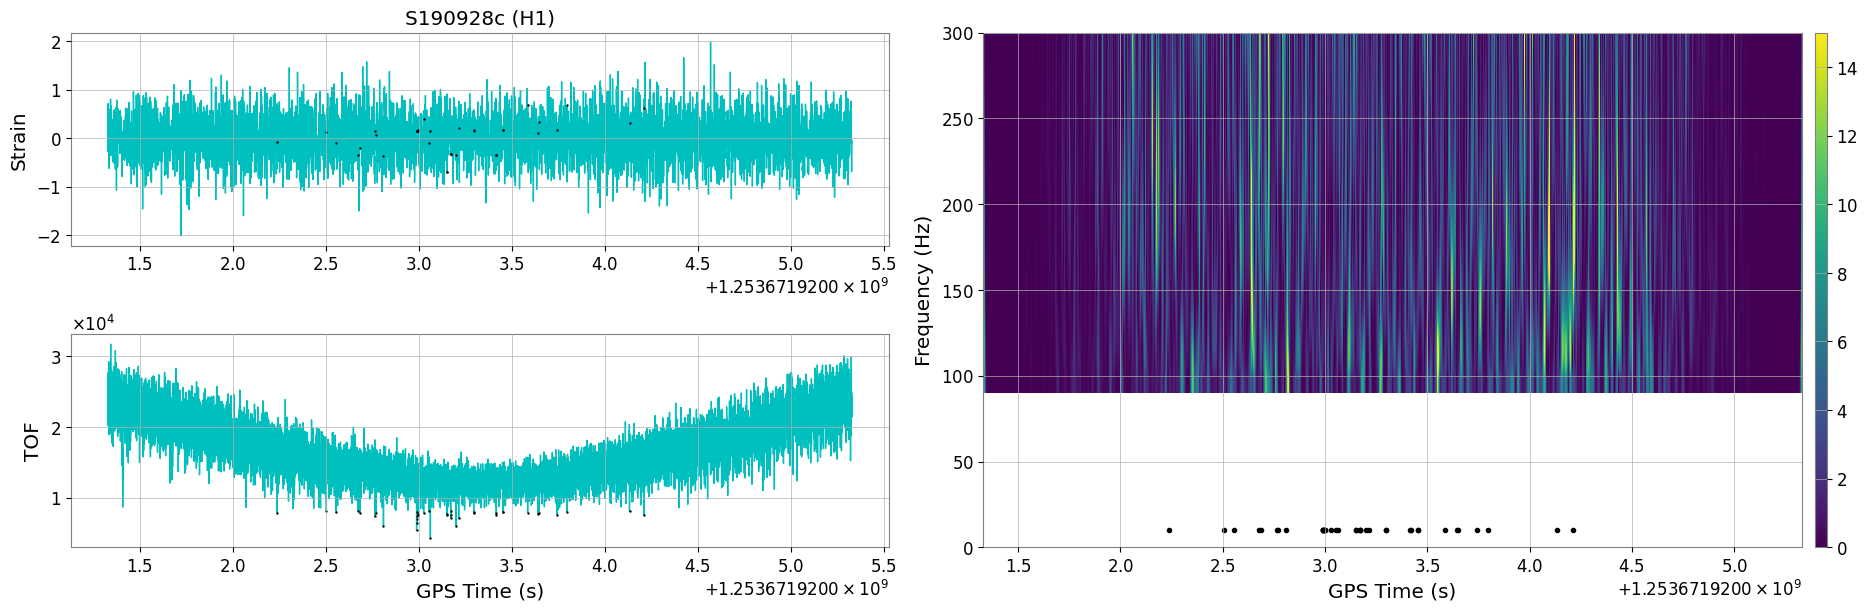

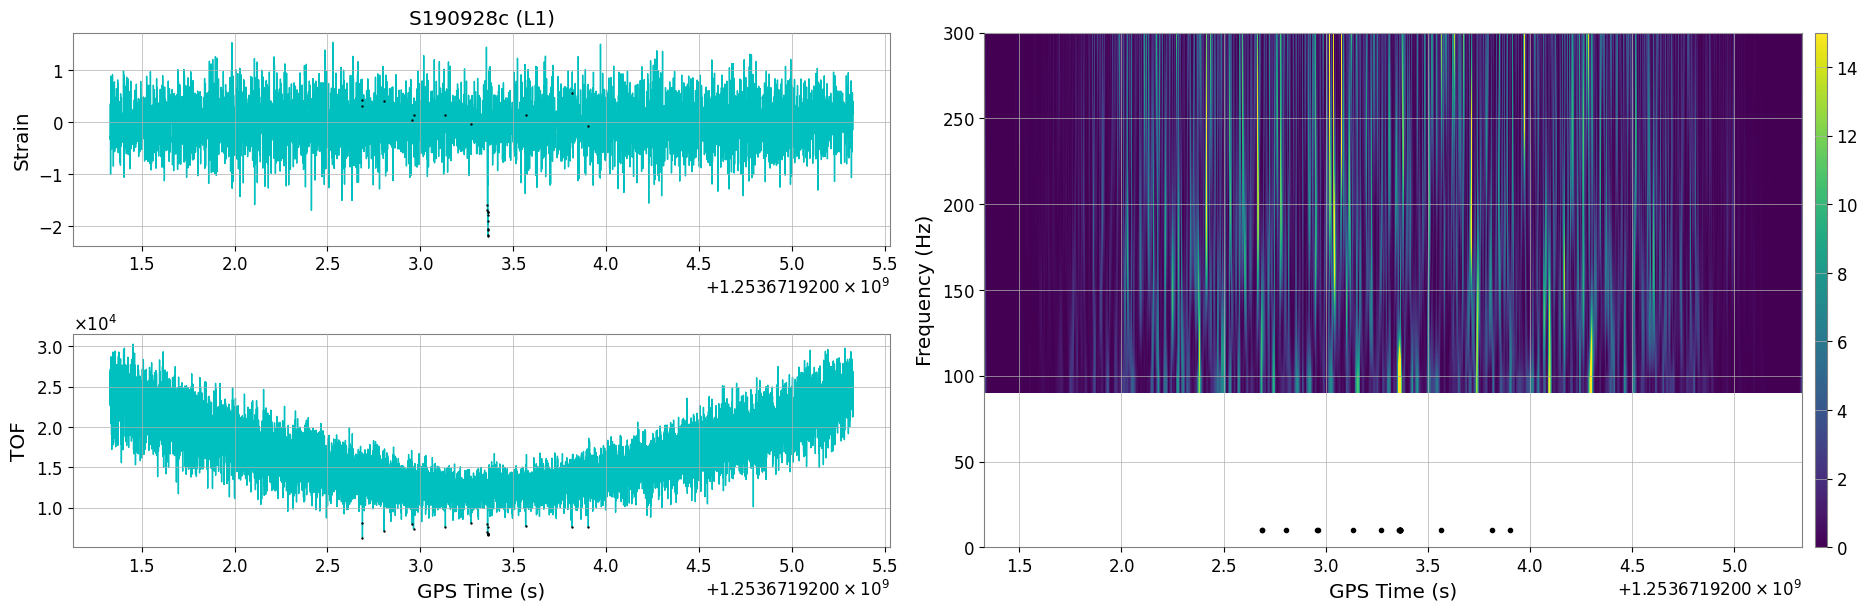

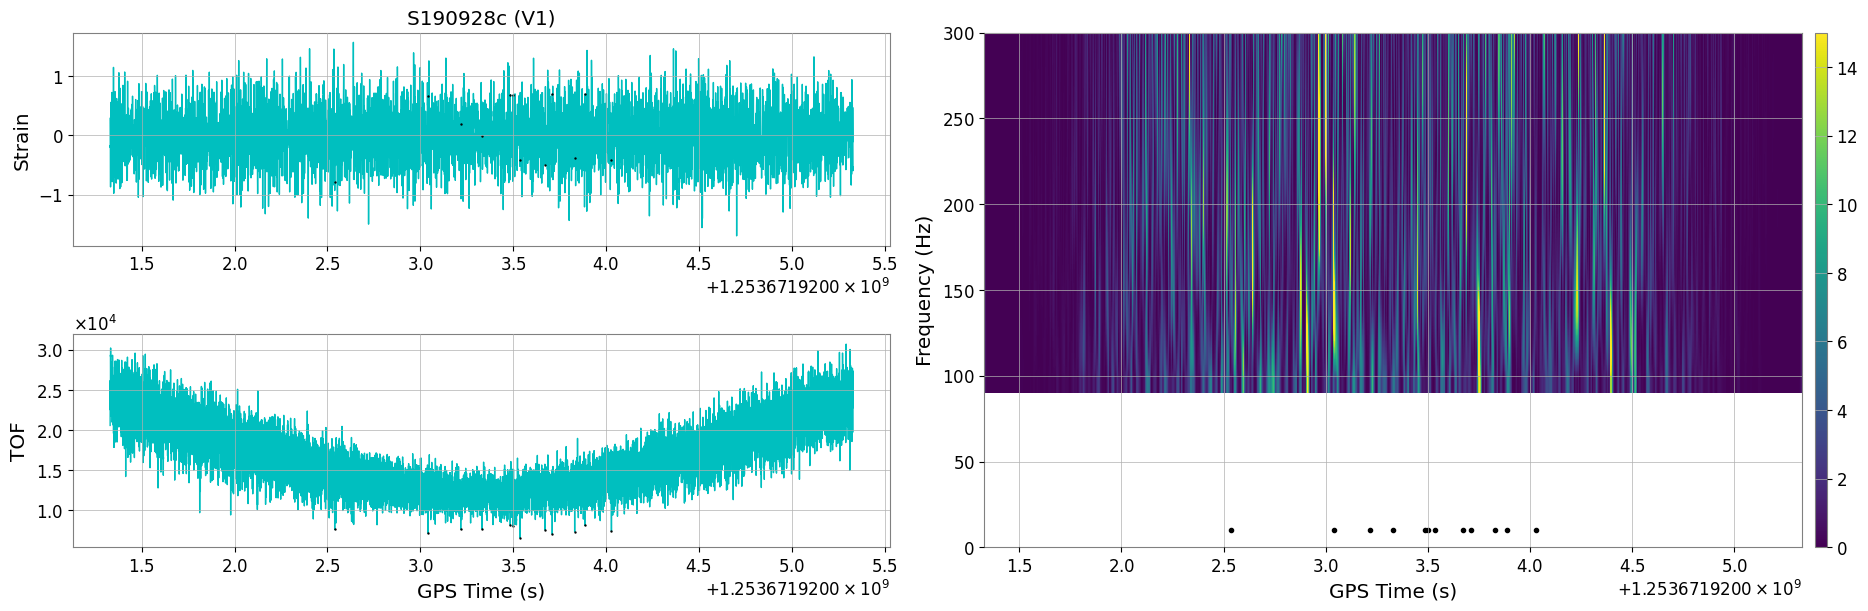

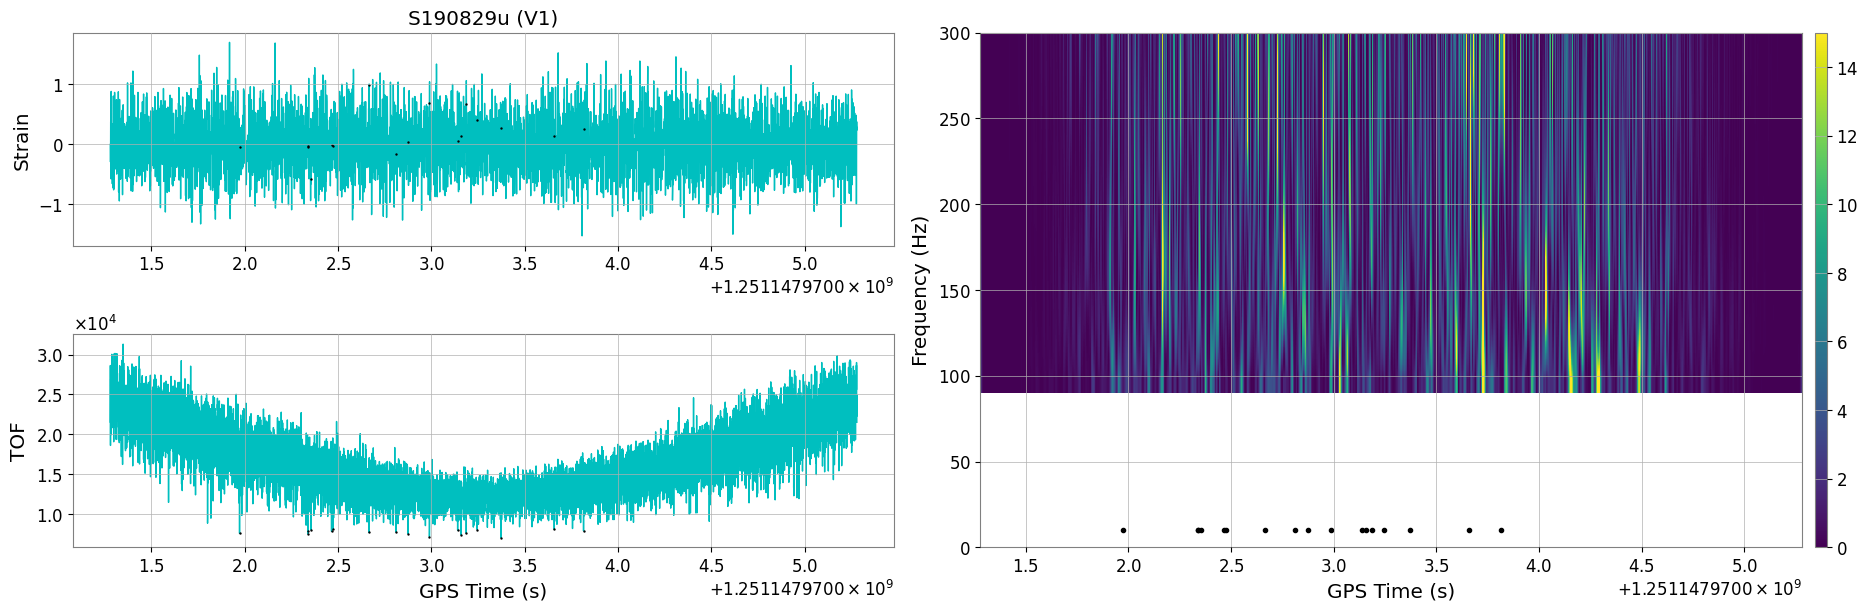

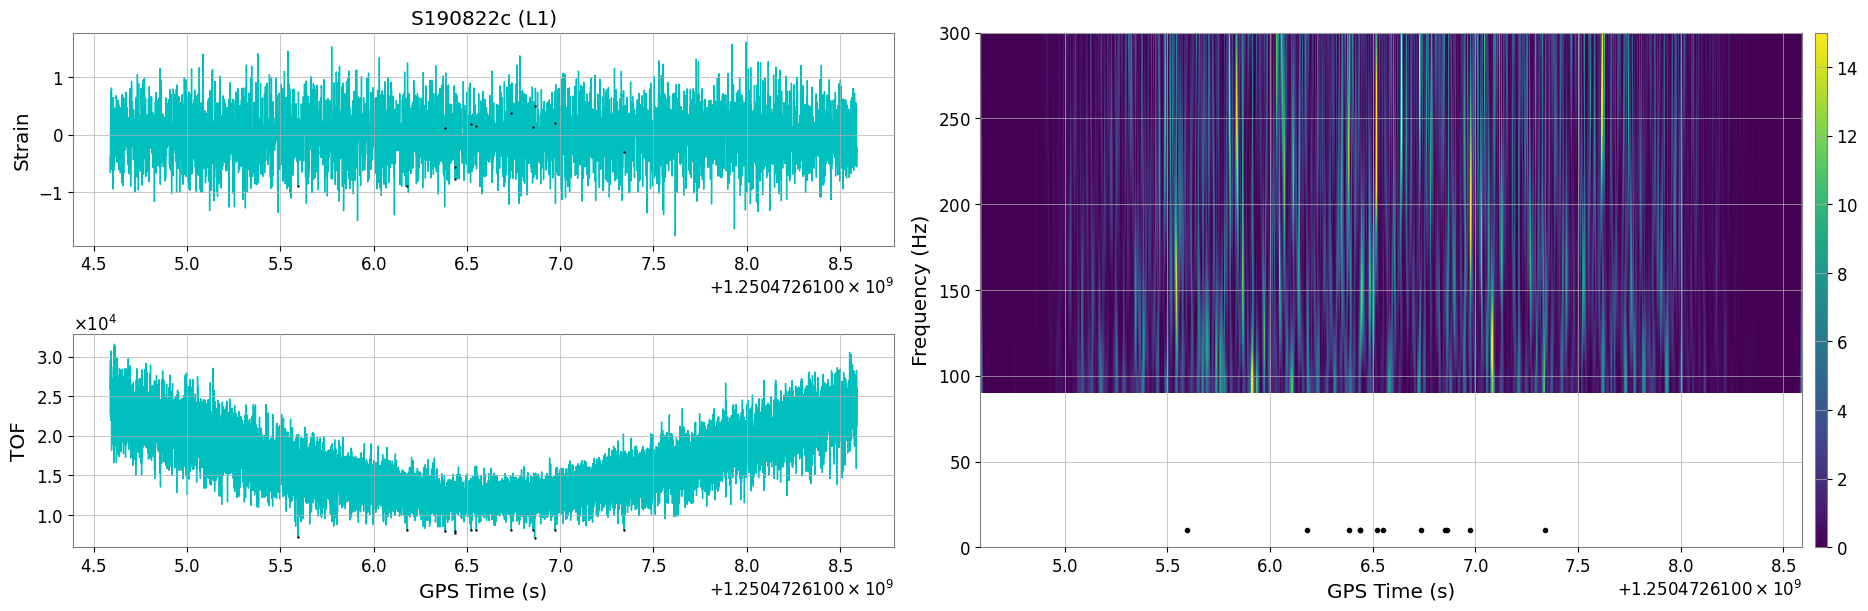

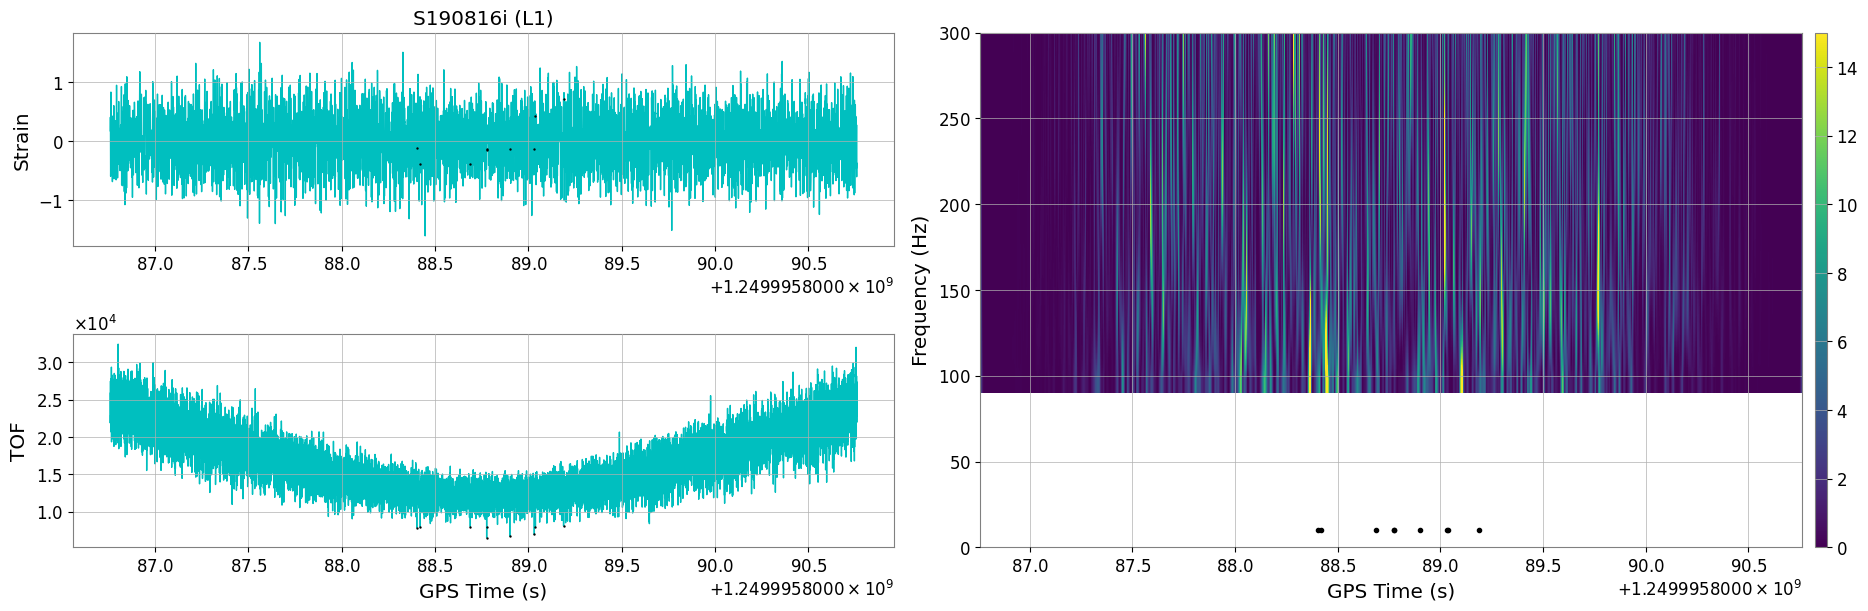

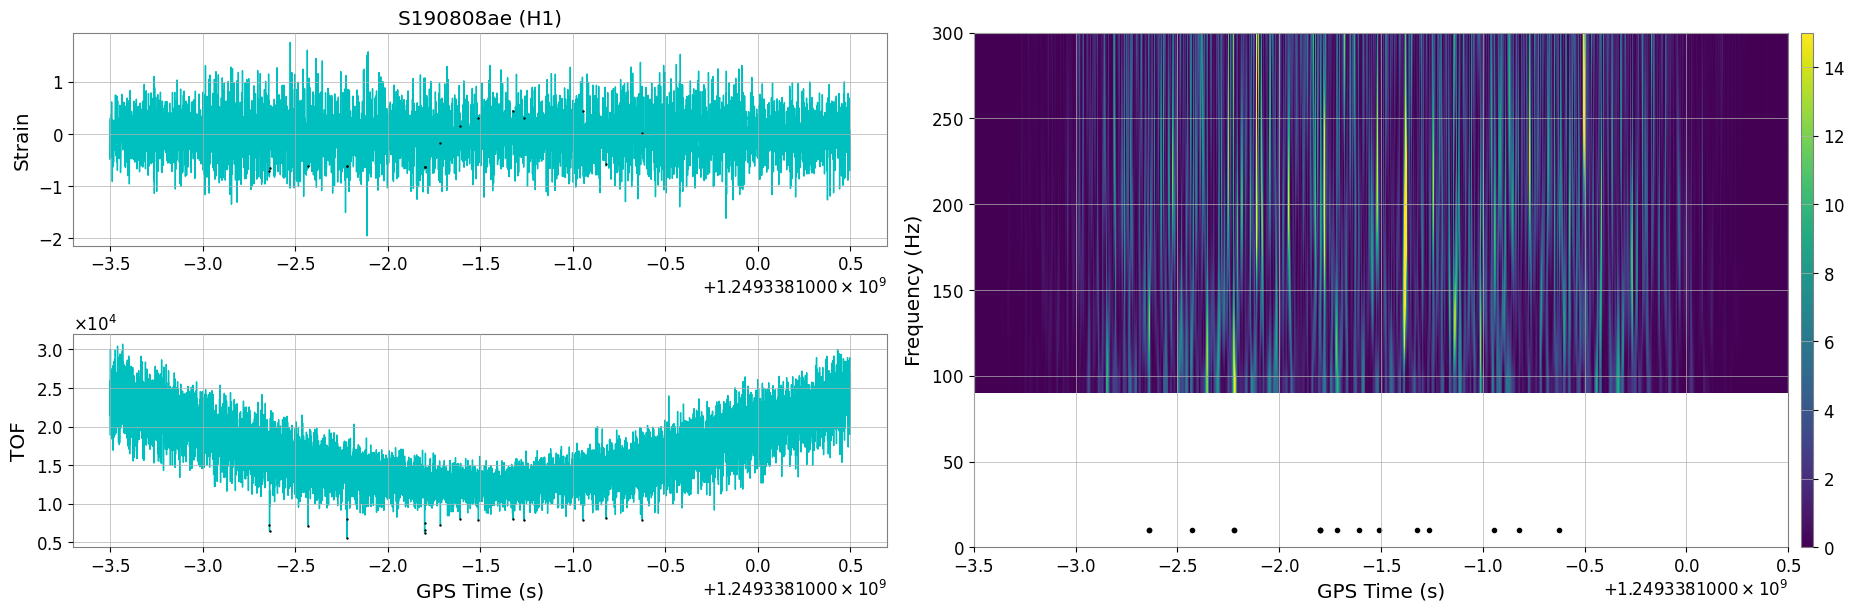

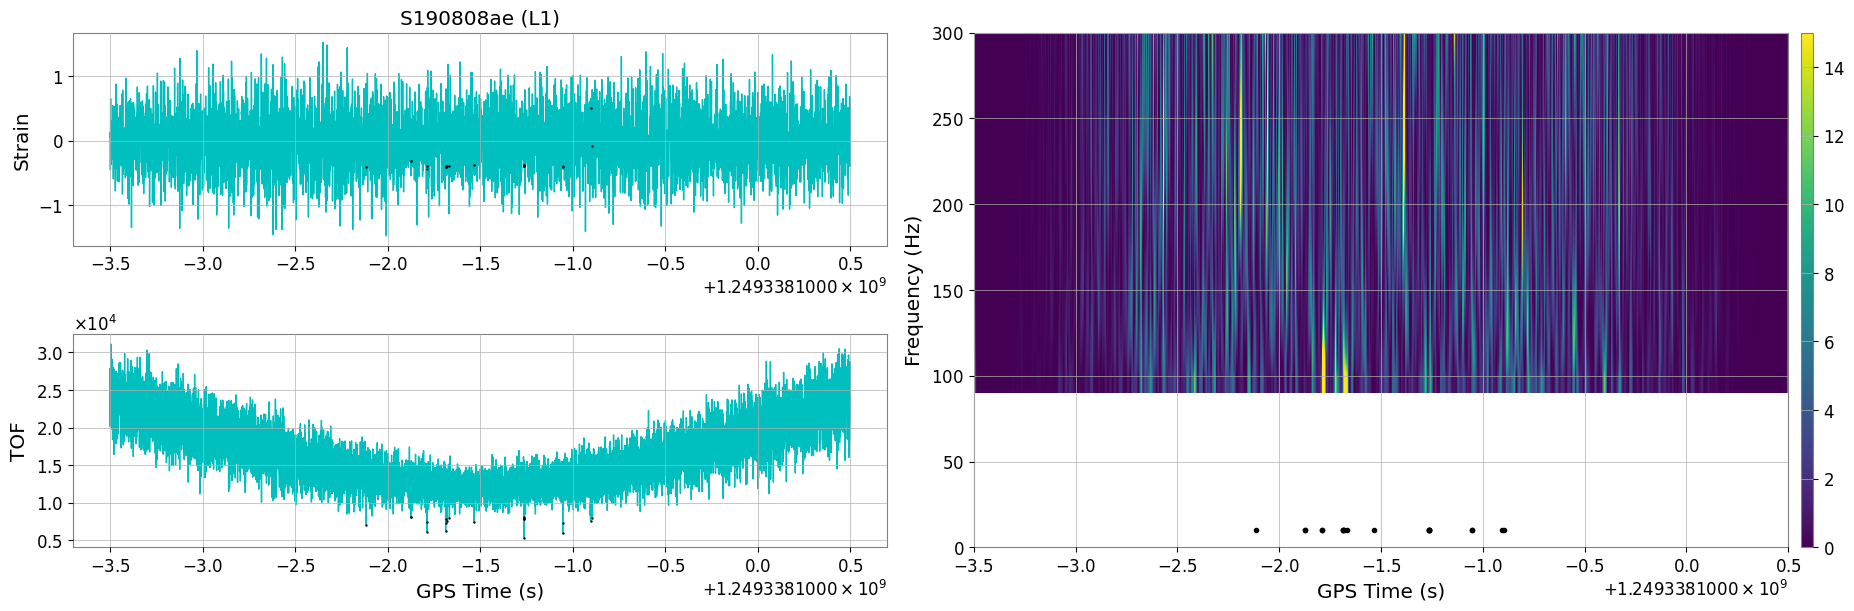

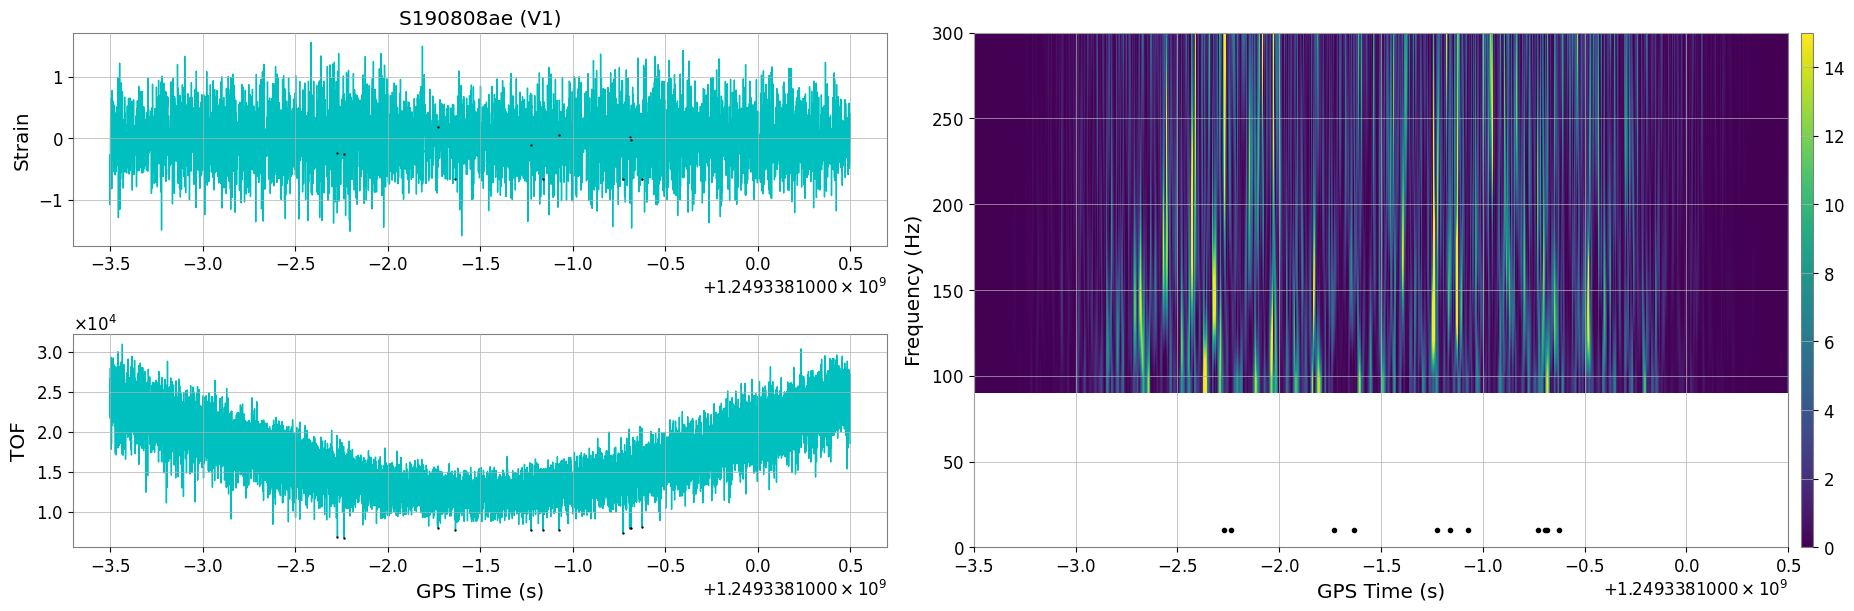

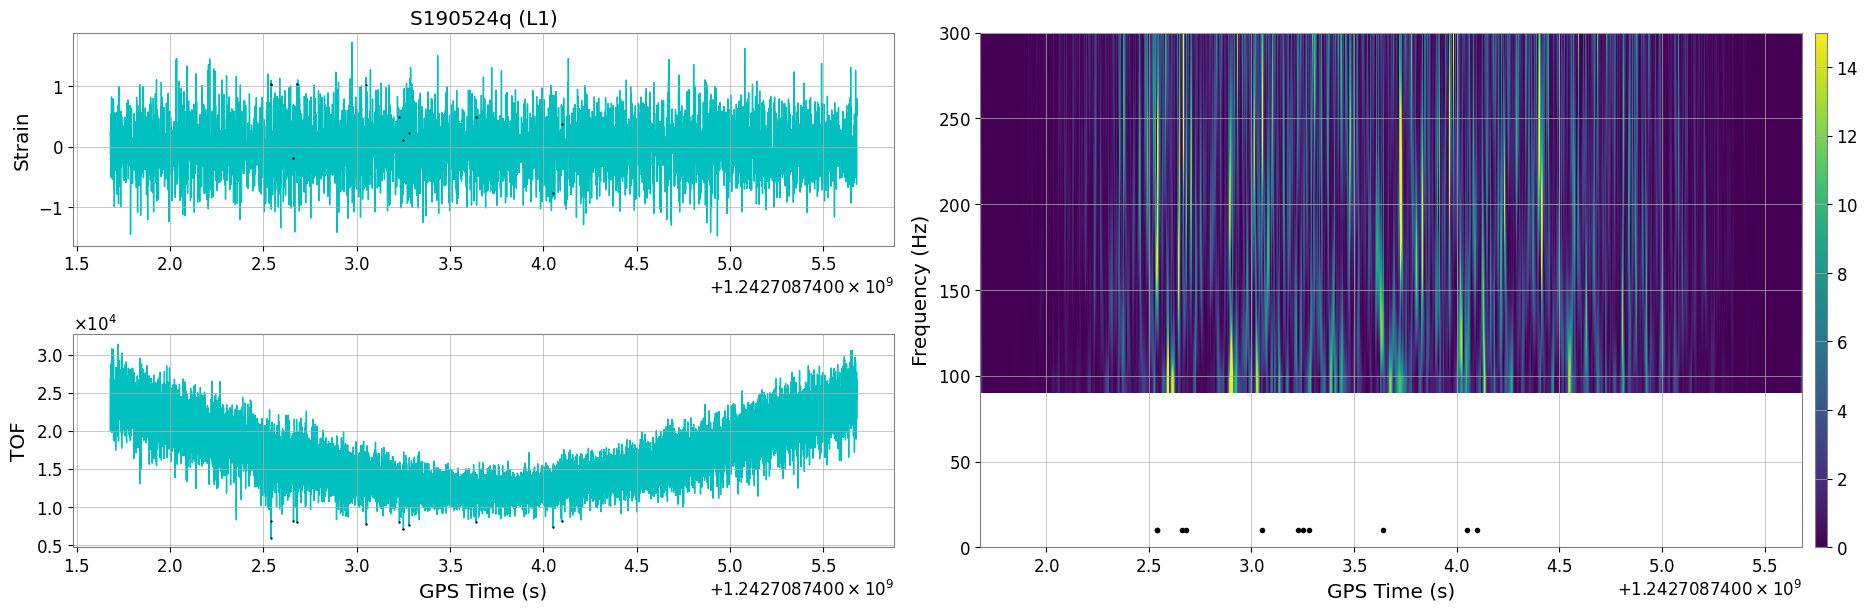

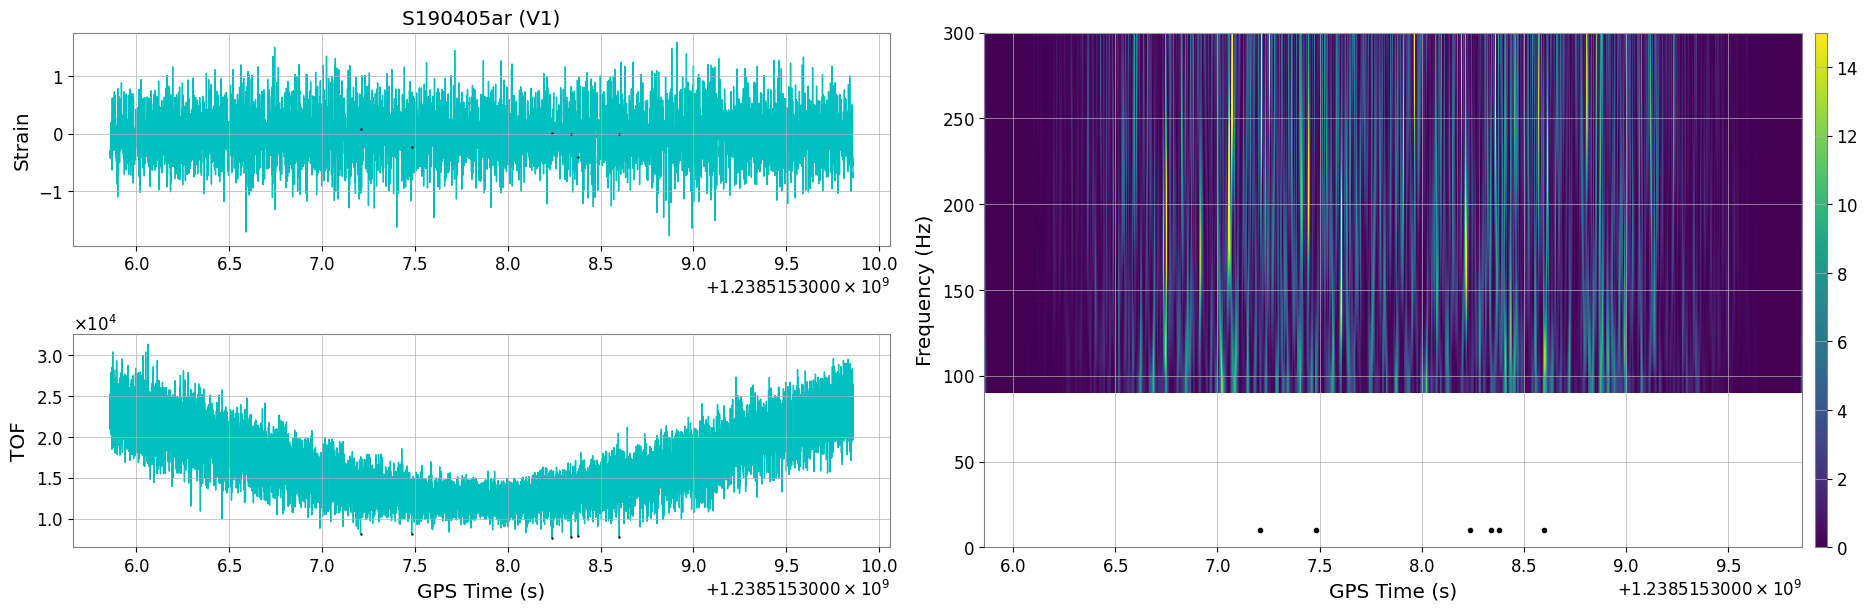

In [7]:
length = 4
dims = 3
k = 20
threshold = 2**13

to_graph = []
for key, val in RETRACTED_O3.items():
    for det in DETECTORS:
        to_graph.append((det, key, val))

for det, key, val in tqdm(to_graph):
    try:
        hdata = get_processed_event(det, val, length=length)
        plot_tof_comparison(
            hdata, title=f'{key} ({det})',
            dims=dims, n_neighbors=k, event_length=threshold
        )
    except ValueError:
        print(
            f'Warning: Cannot find a LOSC dataset at detector {det} for event {key}')